# ResNet50 (A Brief Introduction)

ResNet50 is a convolutional neural network architecture with 50 layers. It is particularly powerful due to the presence of residual connections in its architecture which allows data from one layer to reach later layers by skipping intermediate layers. This eliminates the issue of vanishing gradients which is an issue that prevents a network from learning. This is because the gradient becomes extremely small during backpropagation so the network's weights no longer change.

__The information on ResNet50 was obtained from:__
Kundu N. (23/01/2023), *Exploring ResNet50: An In-Depth Look at the Model Architecture and Code Implementation*, retrieved 10/12/2024 from, https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

__The information on residual connections was obtained from:__
Wong W. (19/12/2021), *What is Residual Connection?*, retrieved 22/01/2025 from, https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55

__The information on vanishing gradients was obtained from:__
Jacob T. (15/06/2023), *Vanishing Gradient Problem: Causes, Consequences, and Solutions*, retrieved 22/01/2025 from, https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html#:~:text=During%20back%20propagation%2C%20a%20neural,will%20decrease%20as%20a%20result.

# Import The Relevant Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
import keras_tuner as kt

# Loading and Preprocessing The Data

In [4]:
# Load Data and Make sure It is Divisible By The Batch_Size
def load_and_truncate(data_class, data_fol = "CNN_Data", batch_size = 32, sim = 0):
    """
    Loads the data and labels. If the user wants to use a particular
    batch_size for training the data then the data and labels
    are truncated such that they are divisible by the batch size.

    Parameters
    ----------
    data_class : str
        Whether the data is "Train", "Test" or "Validation".

    data_fol : str, default = "CNN_Data"
        The folder path of the images and labels.
        
    batch_size : int, default 32
        The batch size you intend to use for the neural network.

    sim : int, default 0
        If sim is 0 then the loaded images and labels will contain
        the simulated images and labels. Otherwise, only the actual
        images and labels will be loaded

    Returns
    -------
    imgs : numpy array
        Arrays containing the relevant collection of images.

    labels : numpy array
        An arrays containing the relevant collection of labels.
    """
    if sim == 0:
        imgs = np.load(f"{data_fol}/{data_class}/{data_class}_With_Sim_Imgs.npy")
        labels = np.load(f"{data_fol}/{data_class}/{data_class}_With_Sim_Labels.npy")
    else:
        imgs = np.load(f"{data_fol}/{data_class}/{data_class}_Imgs.npy")
        labels = np.load(f"{data_fol}/{data_class}/{data_class}_Labels.npy")
    end_pt = len(labels) % batch_size

    if end_pt != 0:
        imgs = imgs[:-end_pt]
        labels = labels[:-end_pt]

    return imgs, labels

In [5]:
train_imgs, train_labels = load_and_truncate("Train")
val_imgs, val_labels = load_and_truncate("Validation", sim = 1)
test_imgs, test_labels = load_and_truncate("Test", sim = 1)

In [6]:
train_imgs.shape

(27680, 120, 120, 3)

In [7]:
# Encode the labels via One Hot Encoding
n_classes = 3
train_labels = to_categorical(train_labels, num_classes=n_classes)
val_labels = to_categorical(val_labels, num_classes=n_classes)
test_labels = to_categorical(test_labels, num_classes=n_classes)

In [8]:
# Preprocess the images
train_imgs = preprocess_input(train_imgs) 
test_imgs = preprocess_input(test_imgs)
val_imgs = preprocess_input(val_imgs)

# Implementing ResNet50 Model

#### Tuning The Hyper-Parameters

__The hyper model code was adapted from:__
omalleyt12's response under the thread *How to tune the number of epochs and batch_size?* on (22/10/2019), retrieved on 10/12/2024 from the github discussion forum: https://github.com/keras-team/keras-tuner/issues/122

__The ResNet50 code was adapted from:__
AVERAGEMN (2019) *Keras Binary Cats & Dogs ResNet 98%*, retrieved on 10/12/2024 from: https://www.kaggle.com/code/donkeys/keras-binary-cats-dogs-resnet-98

__The tuner and hyperparameter code was adapted from:__
TensorFlow Keras documentation (16/08/2024) *Introduction to the Keras Tuner*, retrieved on 10/12/2024 from: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [9]:
class MyHyperModel(kt.HyperModel):
    """
    A class representing a Hyper Model which allows for
    keras tuner to identify the best parameters for
    the ResNet model.
    """
    
    def build(self, hp):
        """
        Builds the ResNet model according
        to a particular set of hyperparameters
    
        Parameters
        ----------
        hp : keras HyperParameters instance
            A HyperParameters Instance which contains the hyperparameters being tested.
    
        Returns
        -------
        resnet_model : keras Sequential model
            A compiled ResNet50 convolutional neural network.
        """
        resnet_model = keras.Sequential()
        
        input_shape = train_imgs[0].shape
        pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                           input_shape=input_shape,
                           pooling='avg',classes=n_classes,
                           weights='imagenet')
        
        # Don't train the pretrained layers
        for layer in pretrained_model.layers:
                layer.trainable=False
        
        resnet_model.add(pretrained_model)
        resnet_model.add(Flatten())
        resnet_model.add(Dense(units=hp.Int("units", min_value=32, max_value=512, step=32), activation='relu'))
        
        # Choose softmax activation for multi-class classification
        resnet_model.add(Dense(n_classes, activation='softmax'))
        resnet_model.build((None, input_shape[0], input_shape[1], input_shape[2]))
        
        # Choose categorical cross entropy loss function for multi-class classification
        resnet_model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),loss='categorical_crossentropy',metrics=['accuracy'])
    
        return resnet_model

    def fit(self, hp, resnet_model, *args, **kwargs):
        """
        Fits the given data and hyperparameters to 
        the input resnet_model.

        Parameters
        ----------
        hp : keras HyperParameters instance
            A HyperParameters Instance which contains the hyperparameters being tested.
    
        resnet_model : keras Sequential model
            A compiled ResNet50 convolutional neural network.
    
        Returns
        -------
        fitted resnet model : keras Sequential model
            A compiled ResNet50 convolutional neural network fitted to the given data,
            with a particular set of hyperparameters.
        """
        return resnet_model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64]),
            **kwargs,
        )

In [10]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="Resnet_tuned_params",
    project_name="Resnet_tune_hypermodel",
)

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
tuner.search(train_imgs, train_labels, epochs = 3, validation_data = (val_imgs, val_labels))

Trial 10 Complete [00h 00m 54s]
val_accuracy: 0.5574596524238586

Best val_accuracy So Far: 0.5907257795333862
Total elapsed time: 00h 10m 35s


In [13]:
tuner.results_summary()

Results summary
Results in Resnet_tuned_params\Resnet_tune_hypermodel
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
units: 224
learning_rate: 0.001
batch_size: 32
Score: 0.5907257795333862

Trial 05 summary
Hyperparameters:
units: 512
learning_rate: 0.0001
batch_size: 16
Score: 0.5836693644523621

Trial 06 summary
Hyperparameters:
units: 256
learning_rate: 0.01
batch_size: 16
Score: 0.5826612710952759

Trial 01 summary
Hyperparameters:
units: 352
learning_rate: 0.0001
batch_size: 32
Score: 0.5776209831237793

Trial 08 summary
Hyperparameters:
units: 192
learning_rate: 0.0001
batch_size: 64
Score: 0.5745967626571655

Trial 00 summary
Hyperparameters:
units: 64
learning_rate: 0.0001
batch_size: 16
Score: 0.5715726017951965

Trial 07 summary
Hyperparameters:
units: 320
learning_rate: 0.0001
batch_size: 32
Score: 0.569556474685669

Trial 04 summary
Hyperparameters:
units: 256
learning_rate: 0.001
batch_size: 32
Score: 0.5604838728

In [14]:
best_hps=tuner.get_best_hyperparameters()[0]

In [15]:
epochs = 100
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_imgs, train_labels, shuffle = True, epochs=epochs, validation_data=(val_imgs, val_labels))

Epoch 1/100
865/865 [==============================] - 18s 18ms/step - loss: 0.7163 - accuracy: 0.6954 - val_loss: 1.1695 - val_accuracy: 0.4990
Epoch 2/100
865/865 [==============================] - 14s 17ms/step - loss: 0.5646 - accuracy: 0.7805 - val_loss: 1.0279 - val_accuracy: 0.5917
Epoch 3/100
865/865 [==============================] - 15s 17ms/step - loss: 0.5057 - accuracy: 0.8046 - val_loss: 1.2198 - val_accuracy: 0.5776
Epoch 4/100
865/865 [==============================] - 15s 17ms/step - loss: 0.4801 - accuracy: 0.8128 - val_loss: 1.0713 - val_accuracy: 0.5786
Epoch 5/100
865/865 [==============================] - 15s 17ms/step - loss: 0.4626 - accuracy: 0.8196 - val_loss: 1.2549 - val_accuracy: 0.5847
Epoch 6/100
865/865 [==============================] - 15s 17ms/step - loss: 0.4548 - accuracy: 0.8208 - val_loss: 1.0007 - val_accuracy: 0.5847
Epoch 7/100
865/865 [==============================] - 14s 17ms/step - loss: 0.4470 - accuracy: 0.8235 - val_loss: 1.1968 - val_ac

# Plot The Loss and Accuracy

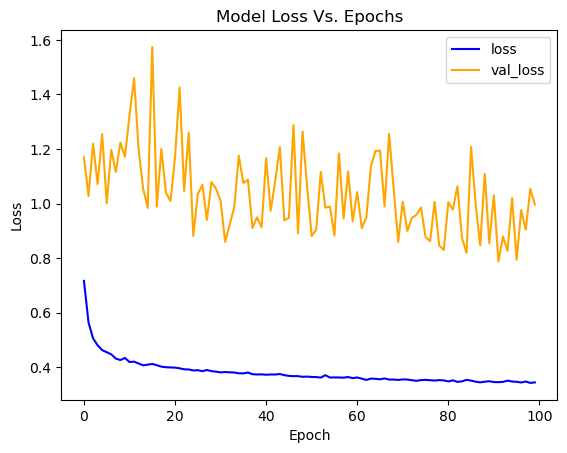

In [16]:
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'orange')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Vs. Epochs')
plt.show()

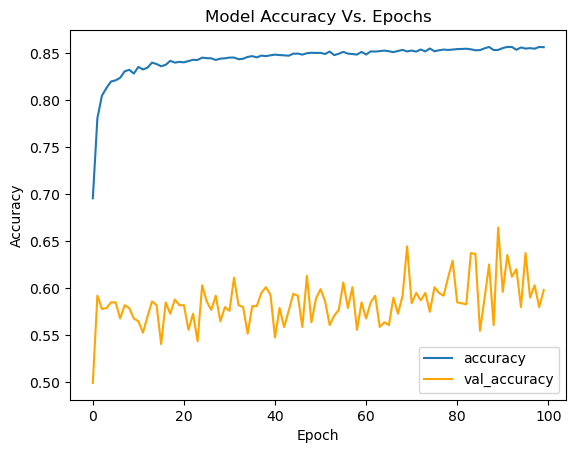

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],'orange')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Vs. Epochs')
plt.show()

Though the ResNet50 model performs better than the VGG-16 model, the increase in accuracy is approximately 7%. With the simulated data, the model performs worse which suggests that the simulated transients are not adequately representative of the actual transients. This may be due to the unaccounted for artefacts that appear in the actual transients' images.

Overall, the poor accuracies and loss curves in the VGG-16 and ResNet50 models suggest that only using the image slices of the sources may not provide an accurate way to classify whether they are transients. This is likely due to the absence of the time dependency in the use of randomised image slices which are essential to the nature of transient phenomena. Time series classification may be a useful alternative to explore.